# Visualization of the celltype data


----

## 0. Environmental setup

In [34]:
import pandas as pd
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
import sys
from PIL import Image
import seaborn as sns

sys.path.append("../../..")
from src.utils.torch.transforms import CustomCenteredCrop

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [65]:
def get_sample_celltype_images(
    md,
    label_col,
    img_loc_col="image_loc",
    dir_prefix="../",
    patient_col="patient",
    n_nuclei=5,
    random_state=1234,
    size=128,
):
    np.random.seed(random_state)
    patients = np.unique(md.loc[:, patient_col])
    cc = CustomCenteredCrop(size)
    print(patients)
    img_dict = {label_col + "+": [], label_col + "-": []}
    for patient in patients:
        patient_md = md.loc[md.loc[:, patient_col] == patient]
        for label in [label_col + "+", label_col + "-"]:
            patient_label_img_locs = np.array(
                patient_md.loc[patient_md.loc[:, label_col] == label, img_loc_col]
            )
            img_locs = np.random.choice(
                patient_label_img_locs, size=n_nuclei, replace=False
            )
            for img_loc in img_locs:
                img = imread(img_loc)
                img = img.max(axis=0)
                img = img[0] * img[-1]
                img = Image.fromarray(img)
                img = np.array(cc(img))
                img_dict[label].append(img)
    return img_dict

<IPython.core.display.Javascript object>

In [80]:
def visualize_images(
    imgs, ncols=5, nrows=6, figsize=[20, 24], size=128, vmin=600, vmax=2 ** 16
):
    fig, ax = plt.subplots(figsize=figsize, ncols=ncols, nrows=nrows)
    ax = ax.flatten()
    for i in range(len(imgs)):
        ax[i].imshow(imgs[i], vmin=600, vmax=vmax)
        ax[i].axis("off")
    fig.tight_layout()
    return fig, ax

<IPython.core.display.Javascript object>

---

## 1. Read in data

In [89]:
img_md = pd.read_csv(
    "../../../data/glioma/classification/preprocessed/image_locs_and_labels.csv",
    index_col=0,
)
img_md.head()

image_loc  \
TileScan 1_Position 1_0  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_1  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_2  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_3  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_4  /home/paysan_d/PycharmProjects/immune_cell_pro...   

                          cd16   cd4   cd8 patient  timepoint  
TileScan 1_Position 1_0  cd16+  cd4-  cd8+     P47          3  
TileScan 1_Position 1_1  cd16+  cd4-  cd8+     P47          3  
TileScan 1_Position 1_2  cd16+  cd4-  cd8+     P47          3  
TileScan 1_Position 1_3  cd16-  cd4+  cd8-     P47          3  
TileScan 1_Position 1_4  cd16-  cd4-  cd8+     P47          3

<IPython.core.display.Javascript object>

---

## 2. Exploratory data analysis

### 2.1. Cell type frequencies

As a first step, we will look at the distribution of the different cell types across the different time steps of all Meningioma patients.

In [90]:
img_md["celltype"] = img_md["cd4"] + img_md["cd8"] + img_md["cd16"]
img_md.head()

image_loc  \
TileScan 1_Position 1_0  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_1  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_2  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_3  /home/paysan_d/PycharmProjects/immune_cell_pro...   
TileScan 1_Position 1_4  /home/paysan_d/PycharmProjects/immune_cell_pro...   

                          cd16   cd4   cd8 patient  timepoint       celltype  
TileScan 1_Position 1_0  cd16+  cd4-  cd8+     P47          3  cd4-cd8+cd16+  
TileScan 1_Position 1_1  cd16+  cd4-  cd8+     P47          3  cd4-cd8+cd16+  
TileScan 1_Position 1_2  cd16+  cd4-  cd8+     P47          3  cd4-cd8+cd16+  
TileScan 1_Position 1_3  cd16-  cd4+  cd8-     P47          3  cd4+cd8-cd16-  
TileScan 1_Position 1_4  cd16-  cd4-  cd8+     P47          3  cd4-cd8+cd16-

<IPython.core.display.Javascript object>

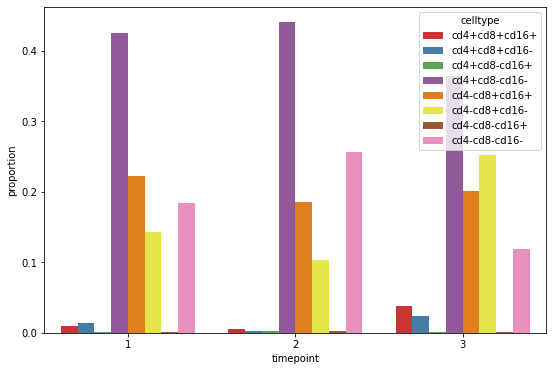

<IPython.core.display.Javascript object>

In [91]:
fig, ax = plt.subplots(figsize=[9, 6])
x, y, hue = "timepoint", "proportion", "celltype"
data = img_md.copy()
data.timepoint = np.array(data.timepoint).astype("object")
l = data[x].groupby(data[hue]).value_counts().rename(y).reset_index()
for cond in np.unique(l["timepoint"]):
    l.loc[l["timepoint"] == cond, "proportion"] /= np.sum(
        l.loc[l["timepoint"] == cond, "proportion"]
    )

l.pipe(
    (sns.barplot, "data"),
    x=x,
    y=y,
    hue=hue,
    order=[1, 2, 3],
    ax=ax,
    palette="Set1",
)
plt.show()

---

### 2.2. Image visualization

We now visualize for cell type marker 5 random nuclei for each of the 8 patient of our dataset that stained positively/negatively for the corresponding cell type marker.

#### CD4

In [66]:
cd4_img_dict = get_sample_celltype_images(img_md, label_col="cd4")

['P27' 'P33' 'P37' 'P38' 'P42' 'P48']


<IPython.core.display.Javascript object>

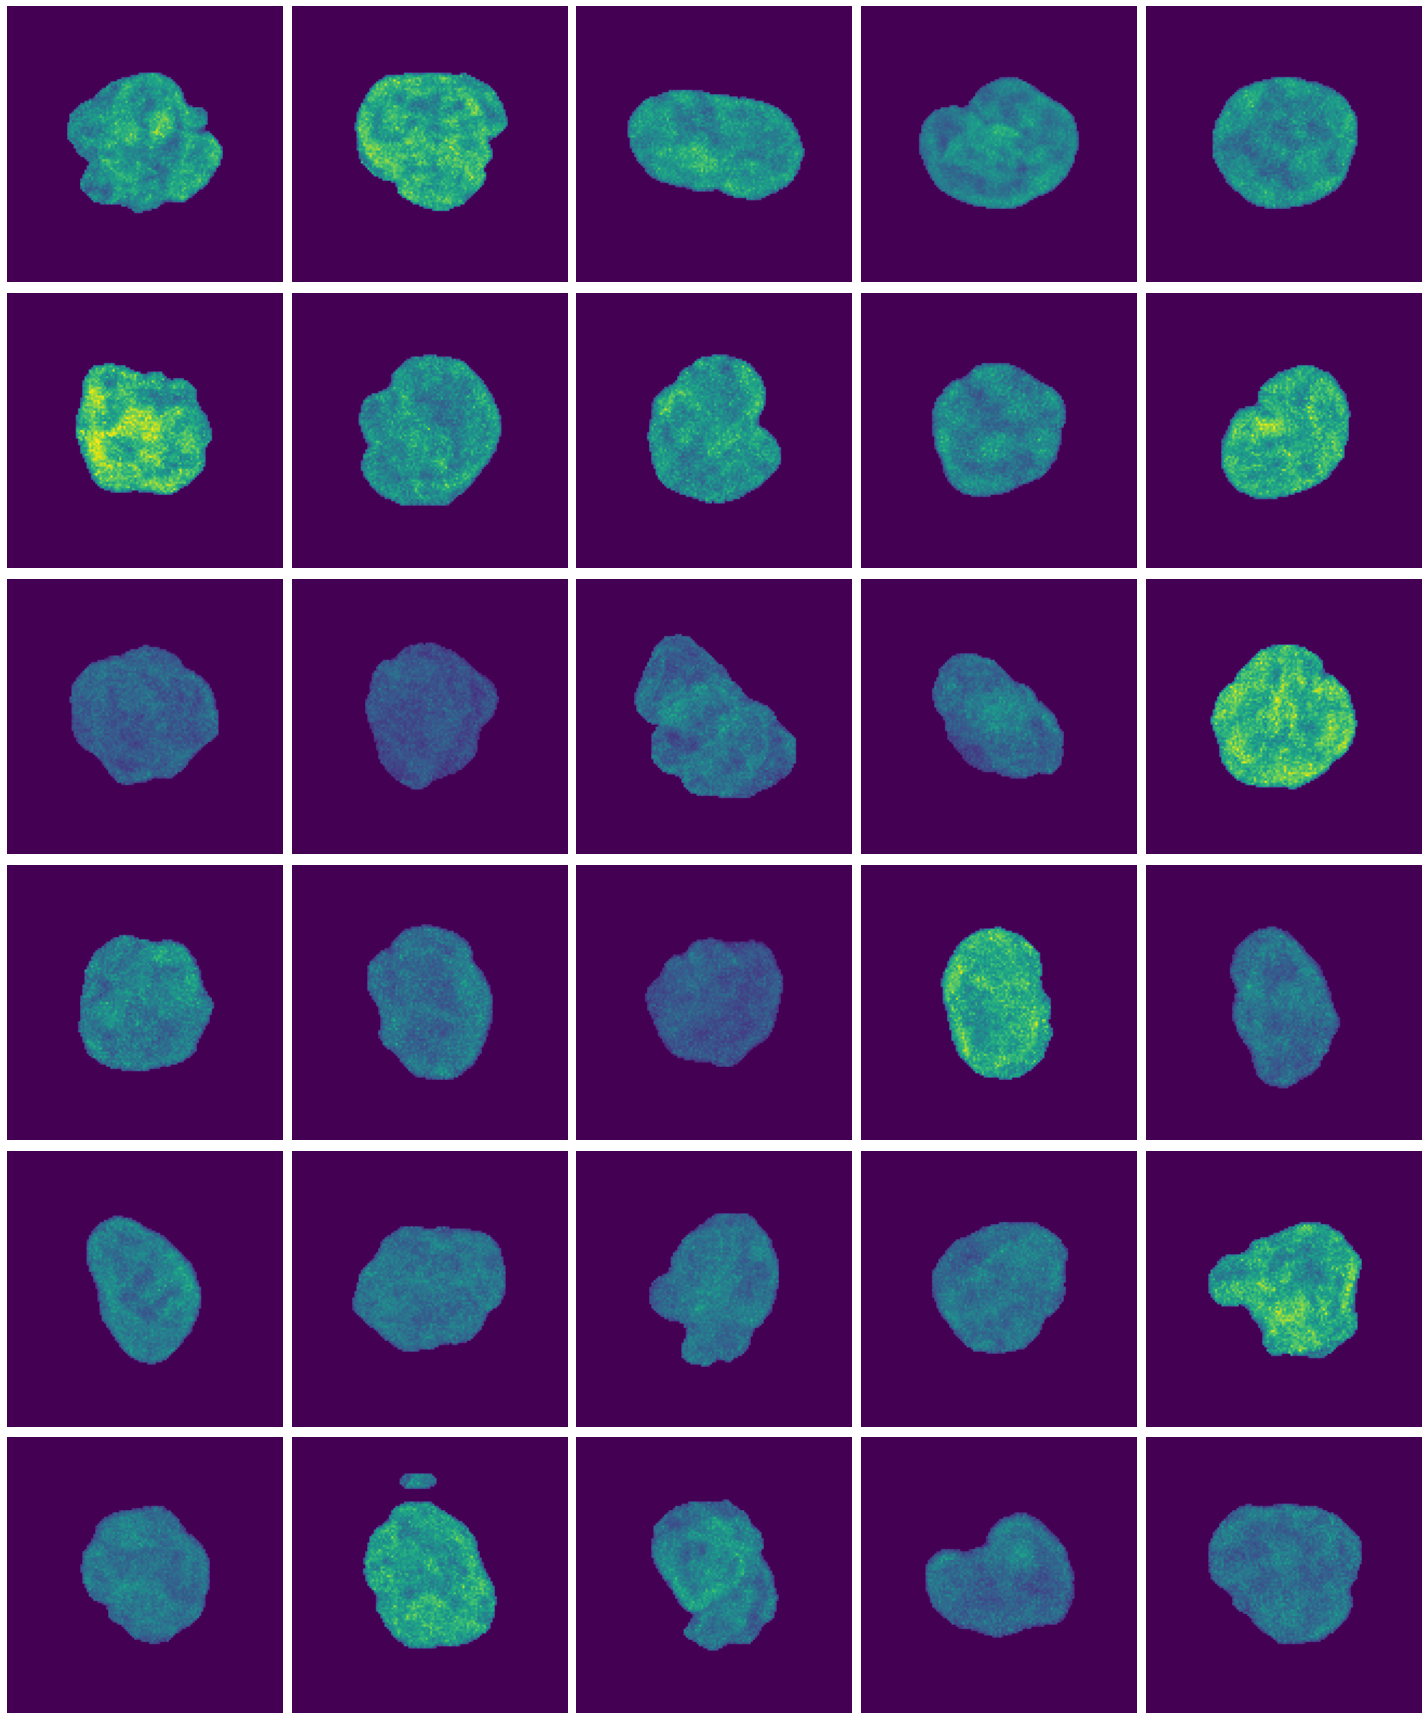

<IPython.core.display.Javascript object>

In [78]:
fig, ax = visualize_images(cd4_img_dict["cd4+"], ncols=5, nrows=6)

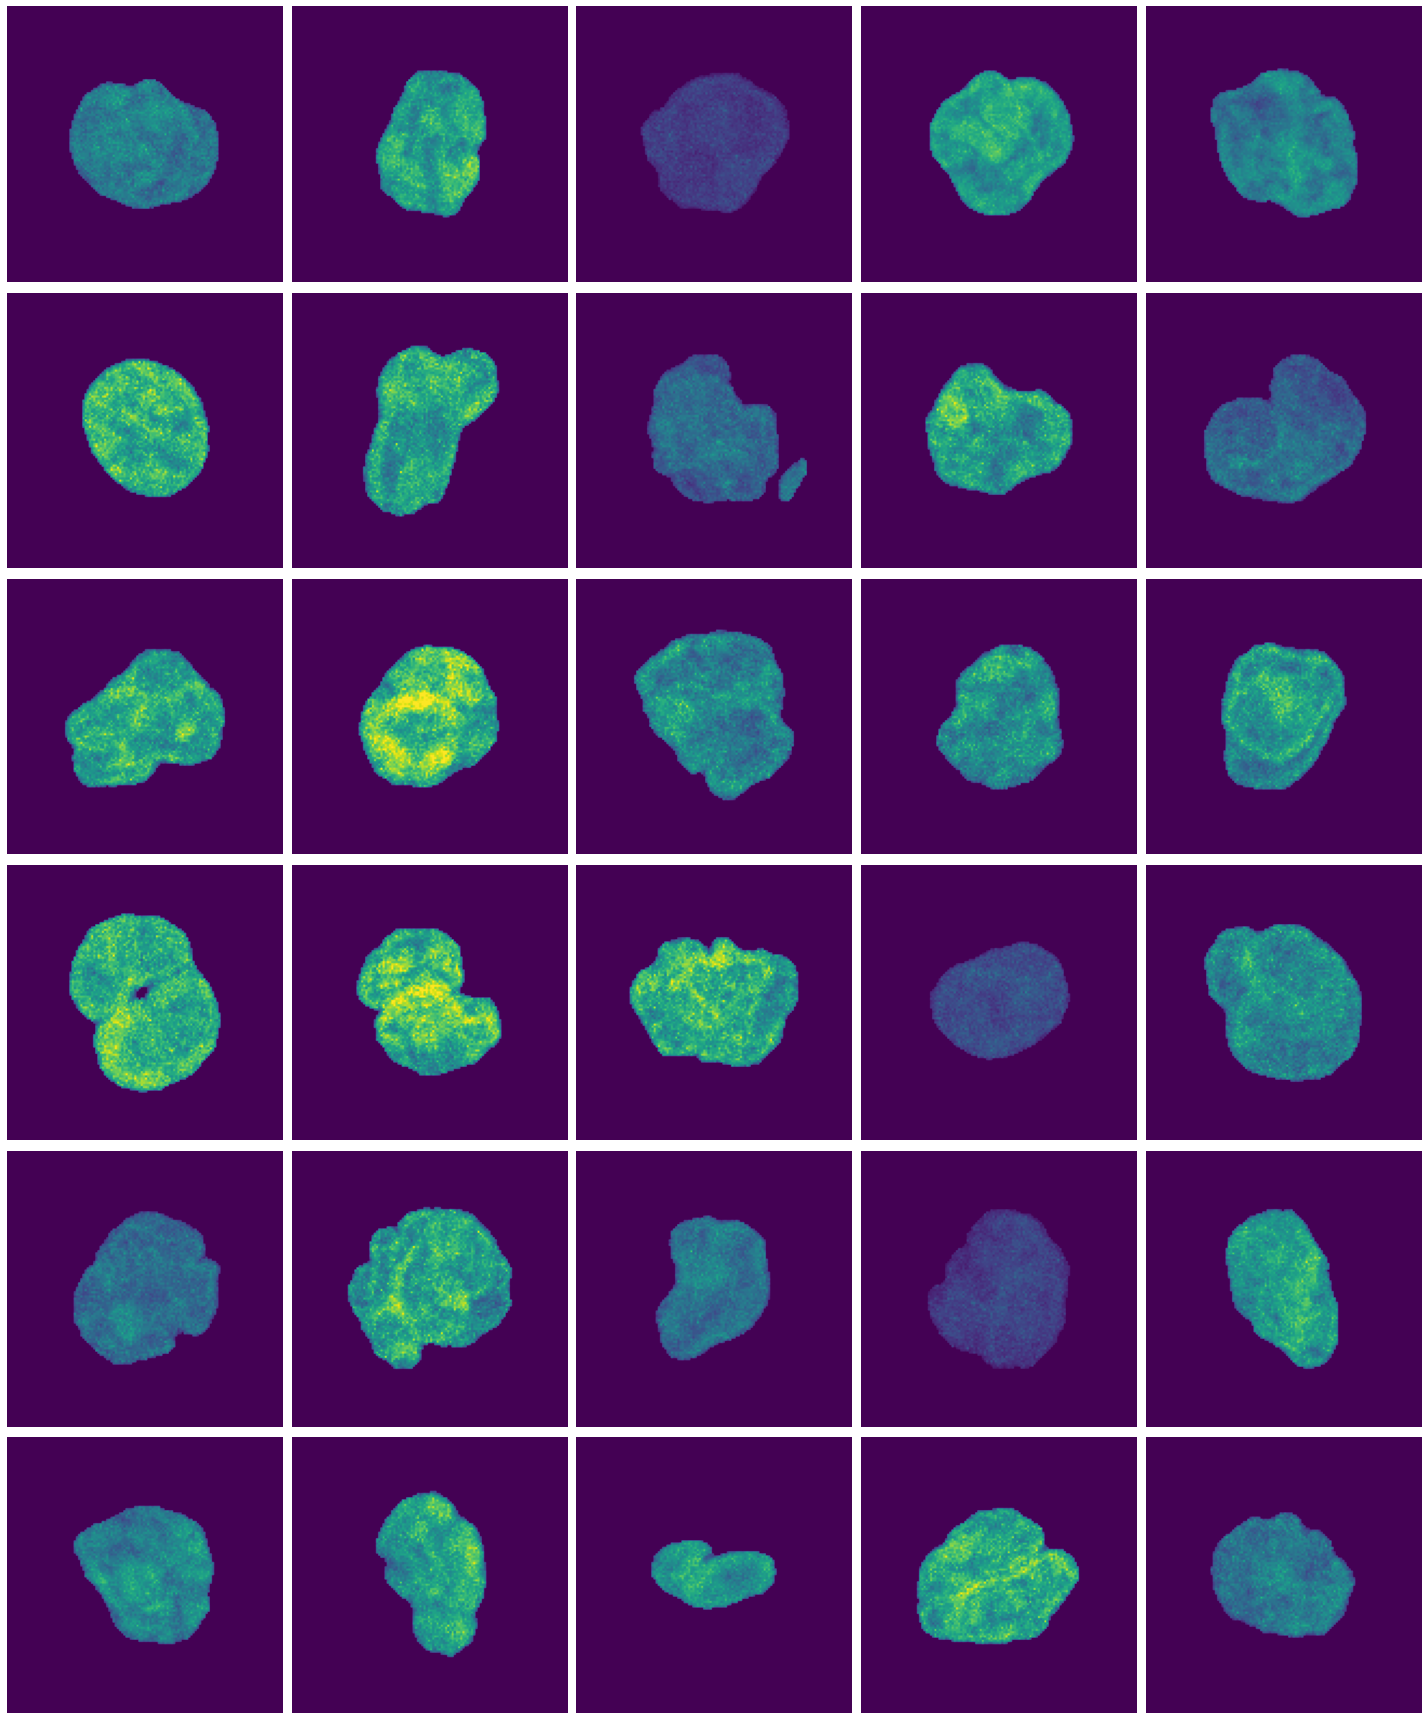

<IPython.core.display.Javascript object>

In [79]:
fig, ax = visualize_images(cd4_img_dict["cd4-"], ncols=5, nrows=6)

---

#### CD8

In [83]:
cd8_img_dict = get_sample_celltype_images(img_md, label_col="cd8")

['P27' 'P33' 'P37' 'P38' 'P42' 'P48']


<IPython.core.display.Javascript object>

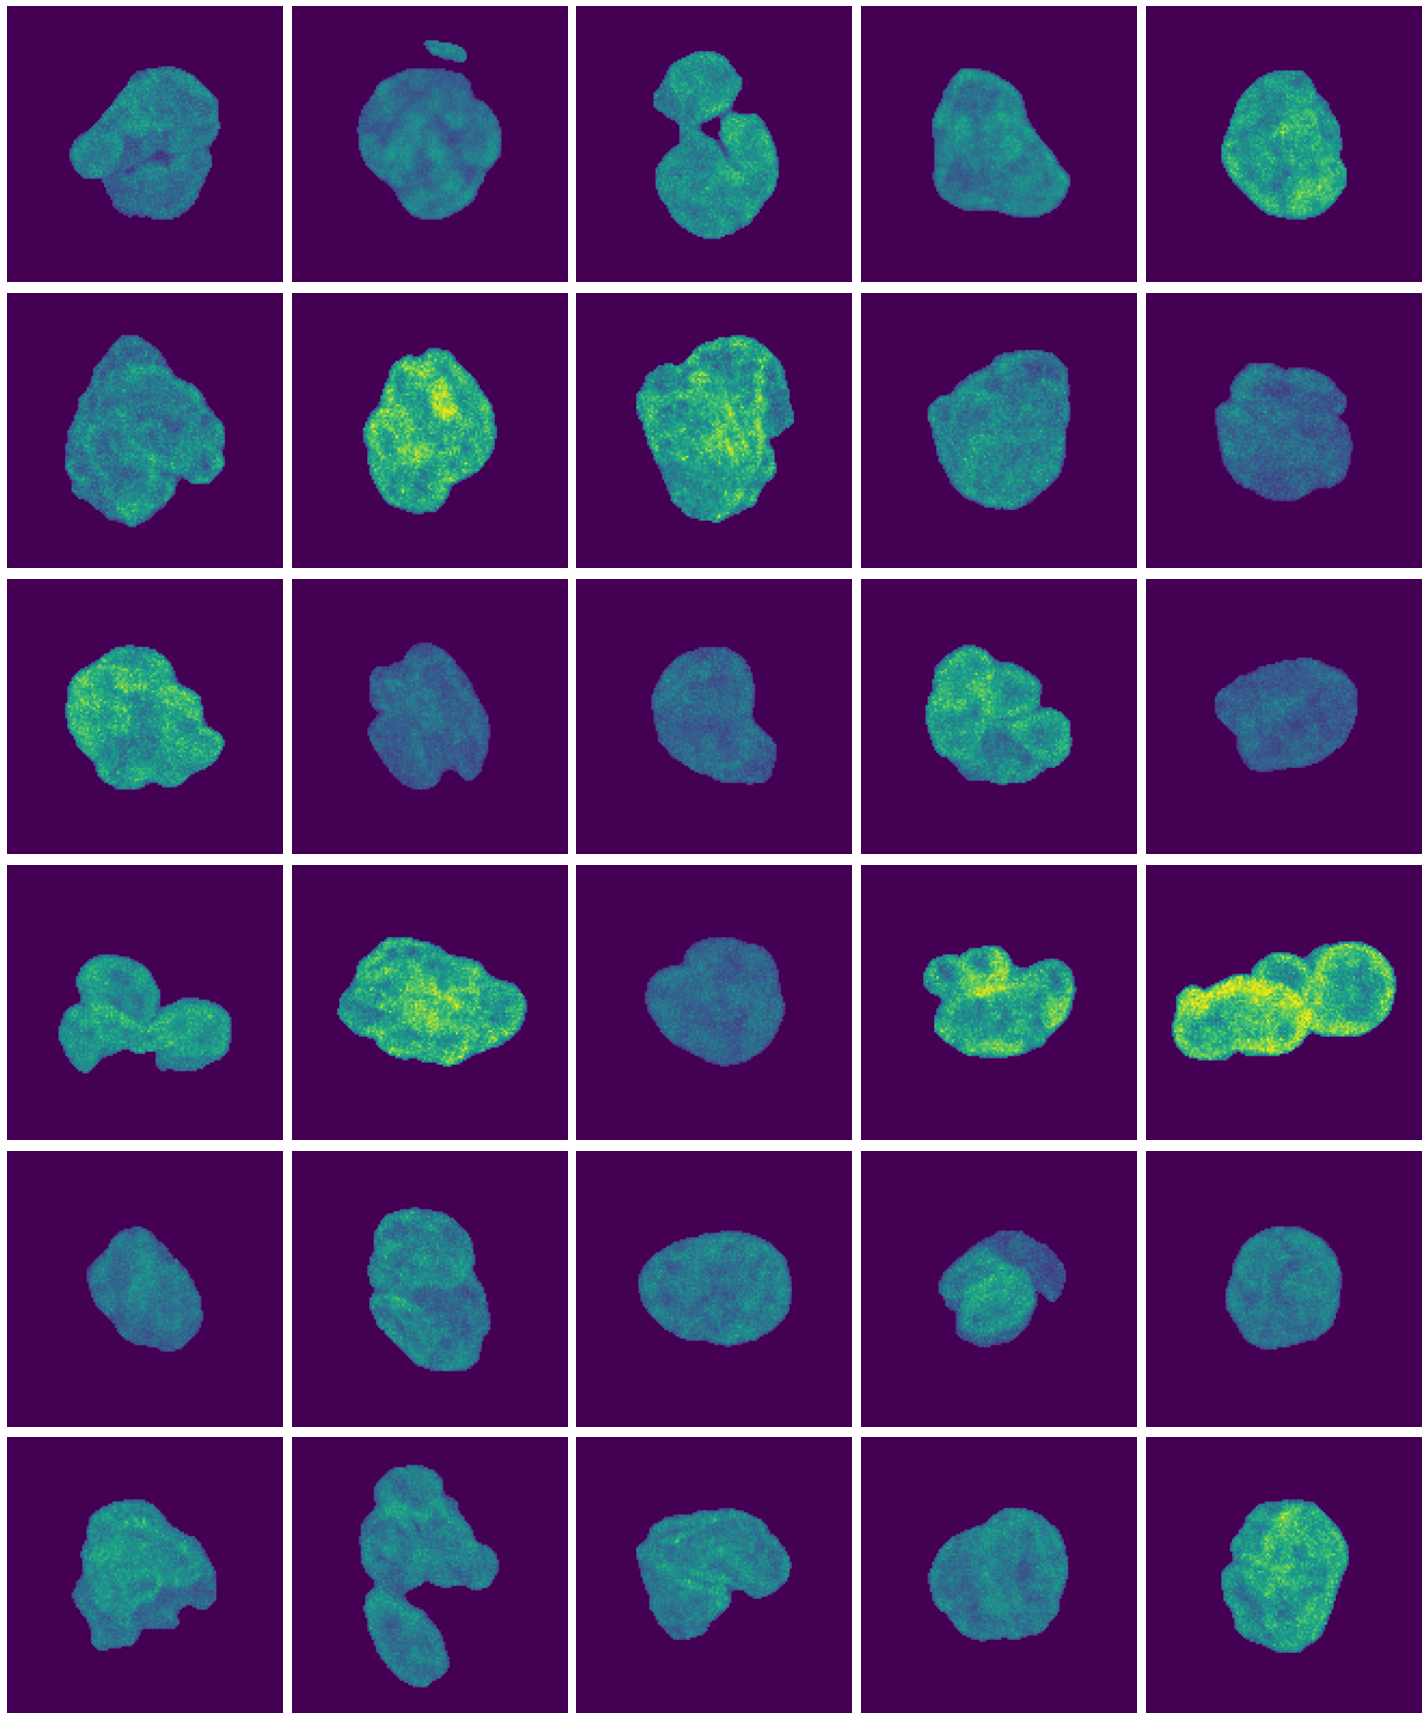

<IPython.core.display.Javascript object>

In [84]:
fig, ax = visualize_images(cd8_img_dict["cd8+"], ncols=5, nrows=6)

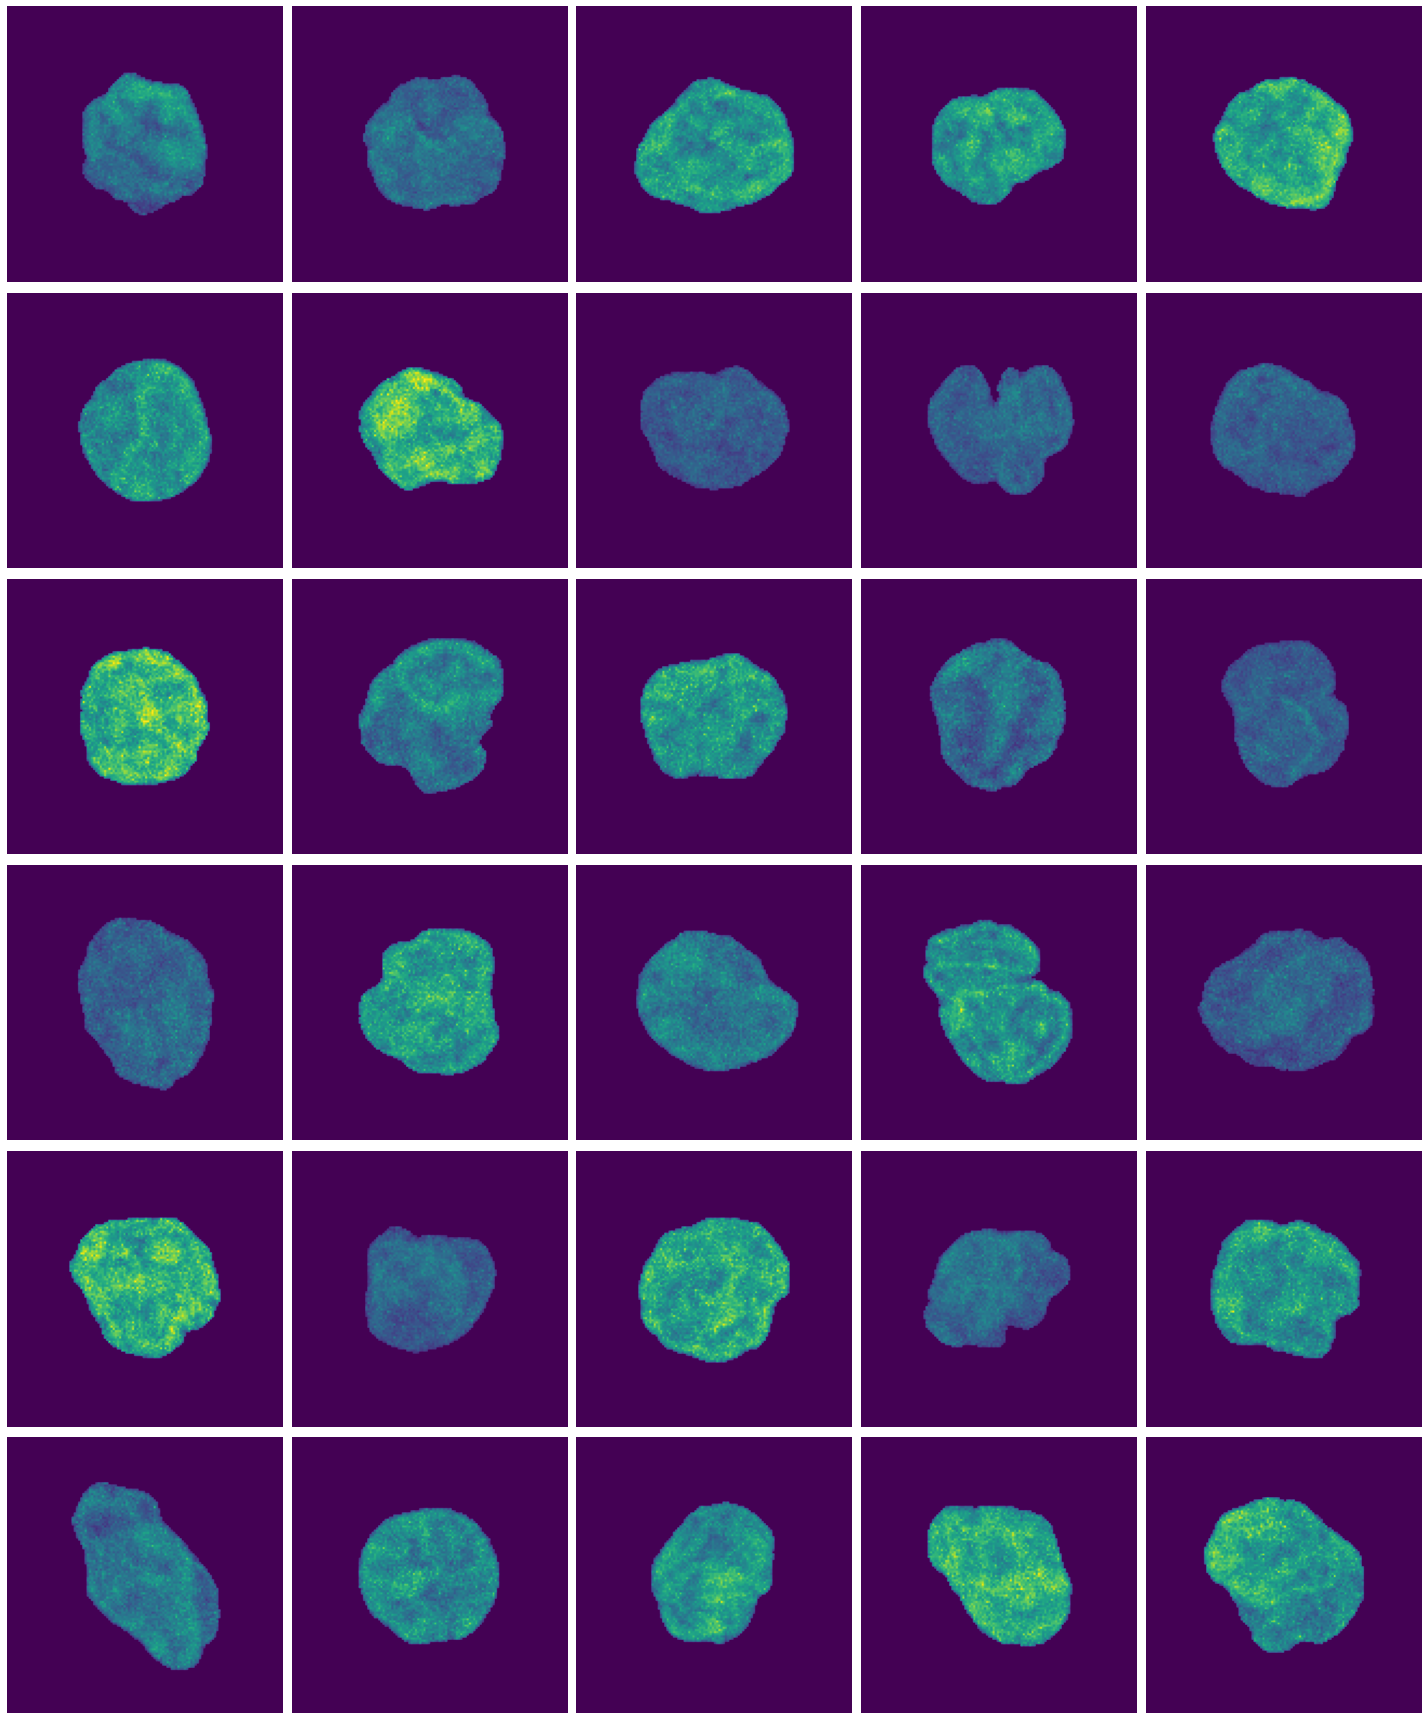

<IPython.core.display.Javascript object>

In [85]:
fig, ax = visualize_images(cd8_img_dict["cd8-"], ncols=5, nrows=6)

---

#### CD16

In [86]:
cd16_img_dict = get_sample_celltype_images(img_md, label_col="cd16")

['P27' 'P33' 'P37' 'P38' 'P42' 'P48']


<IPython.core.display.Javascript object>

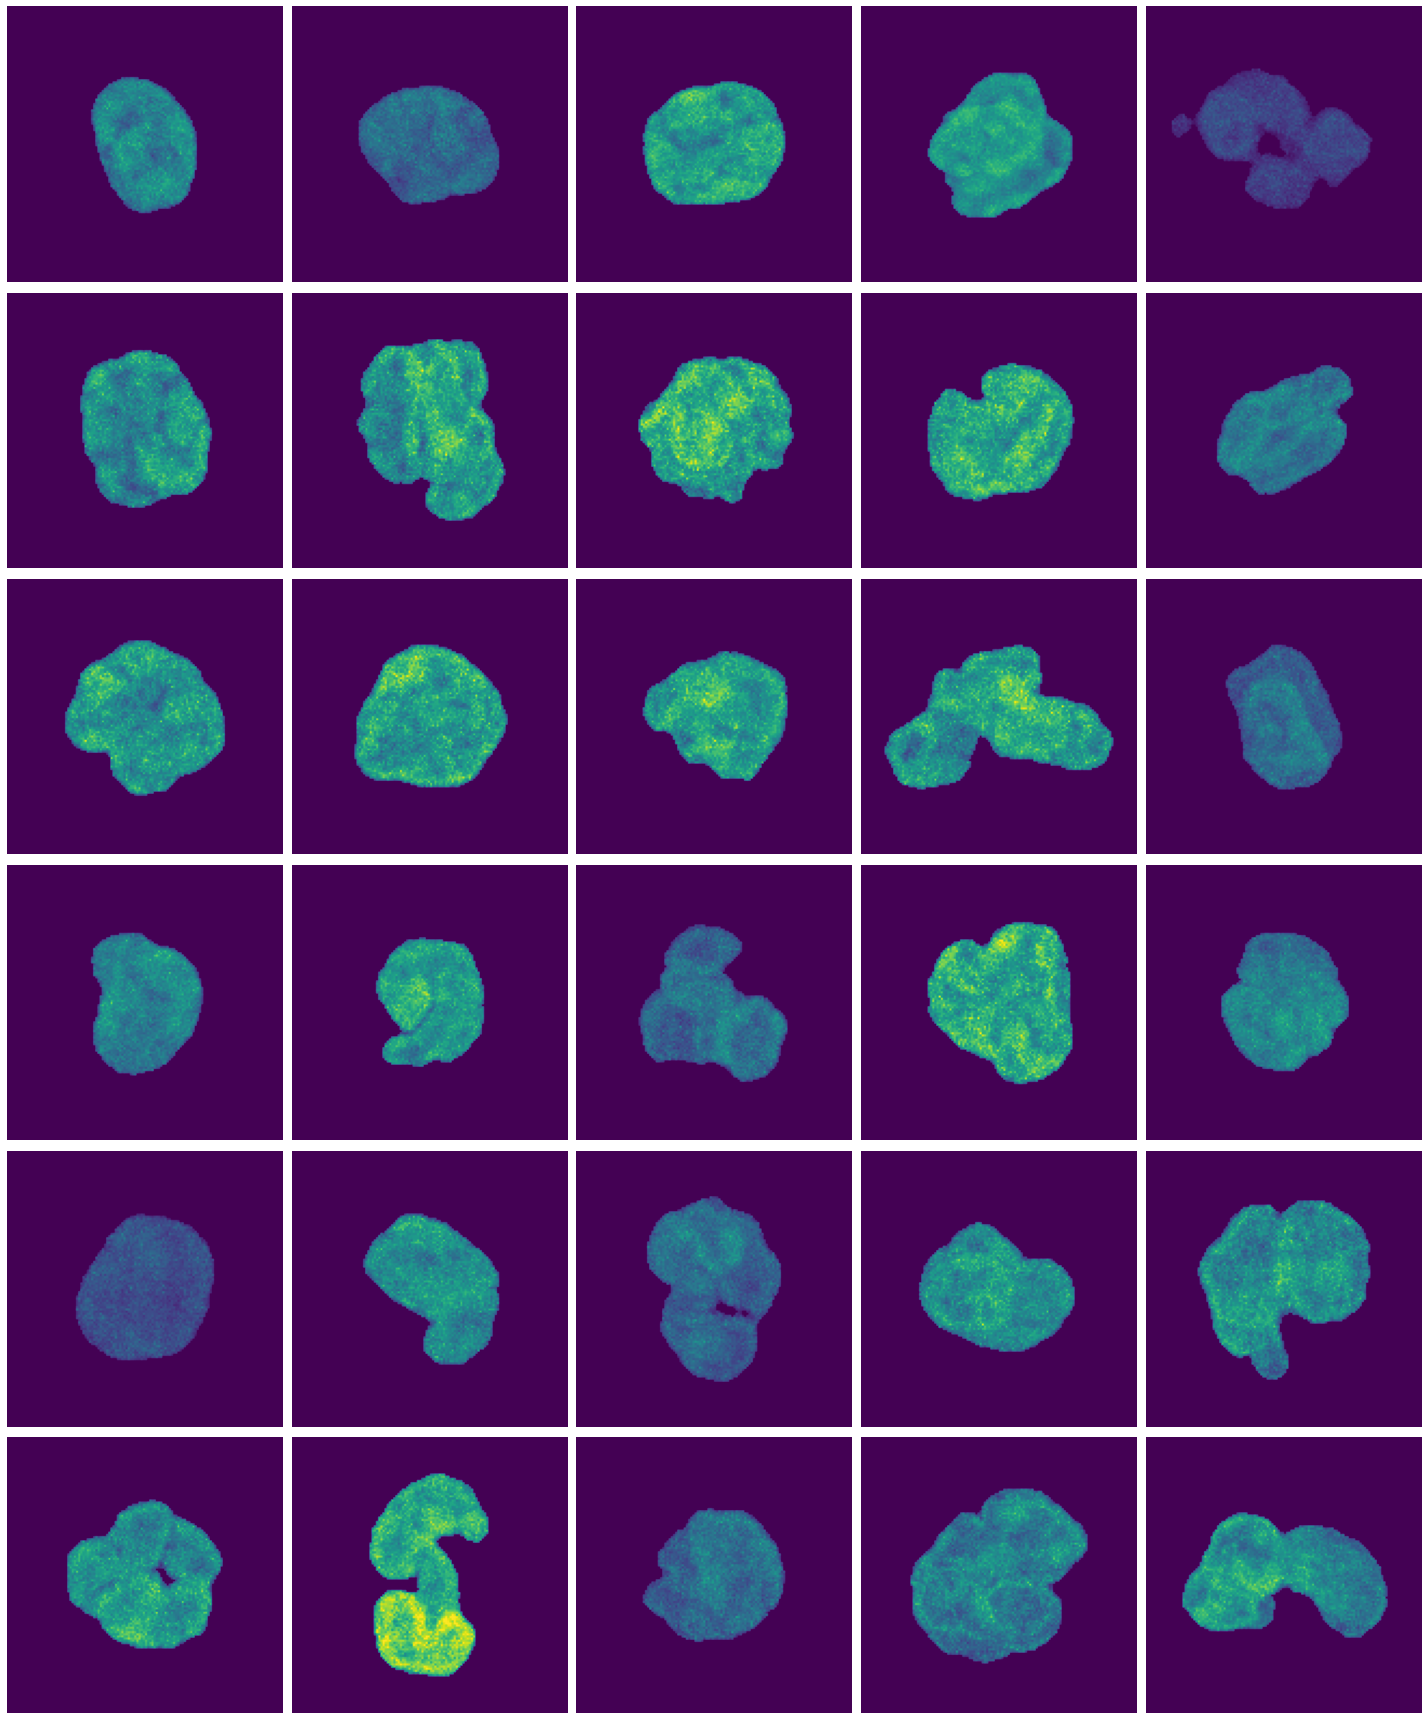

<IPython.core.display.Javascript object>

In [87]:
fig, ax = visualize_images(cd16_img_dict["cd16+"], ncols=5, nrows=6)

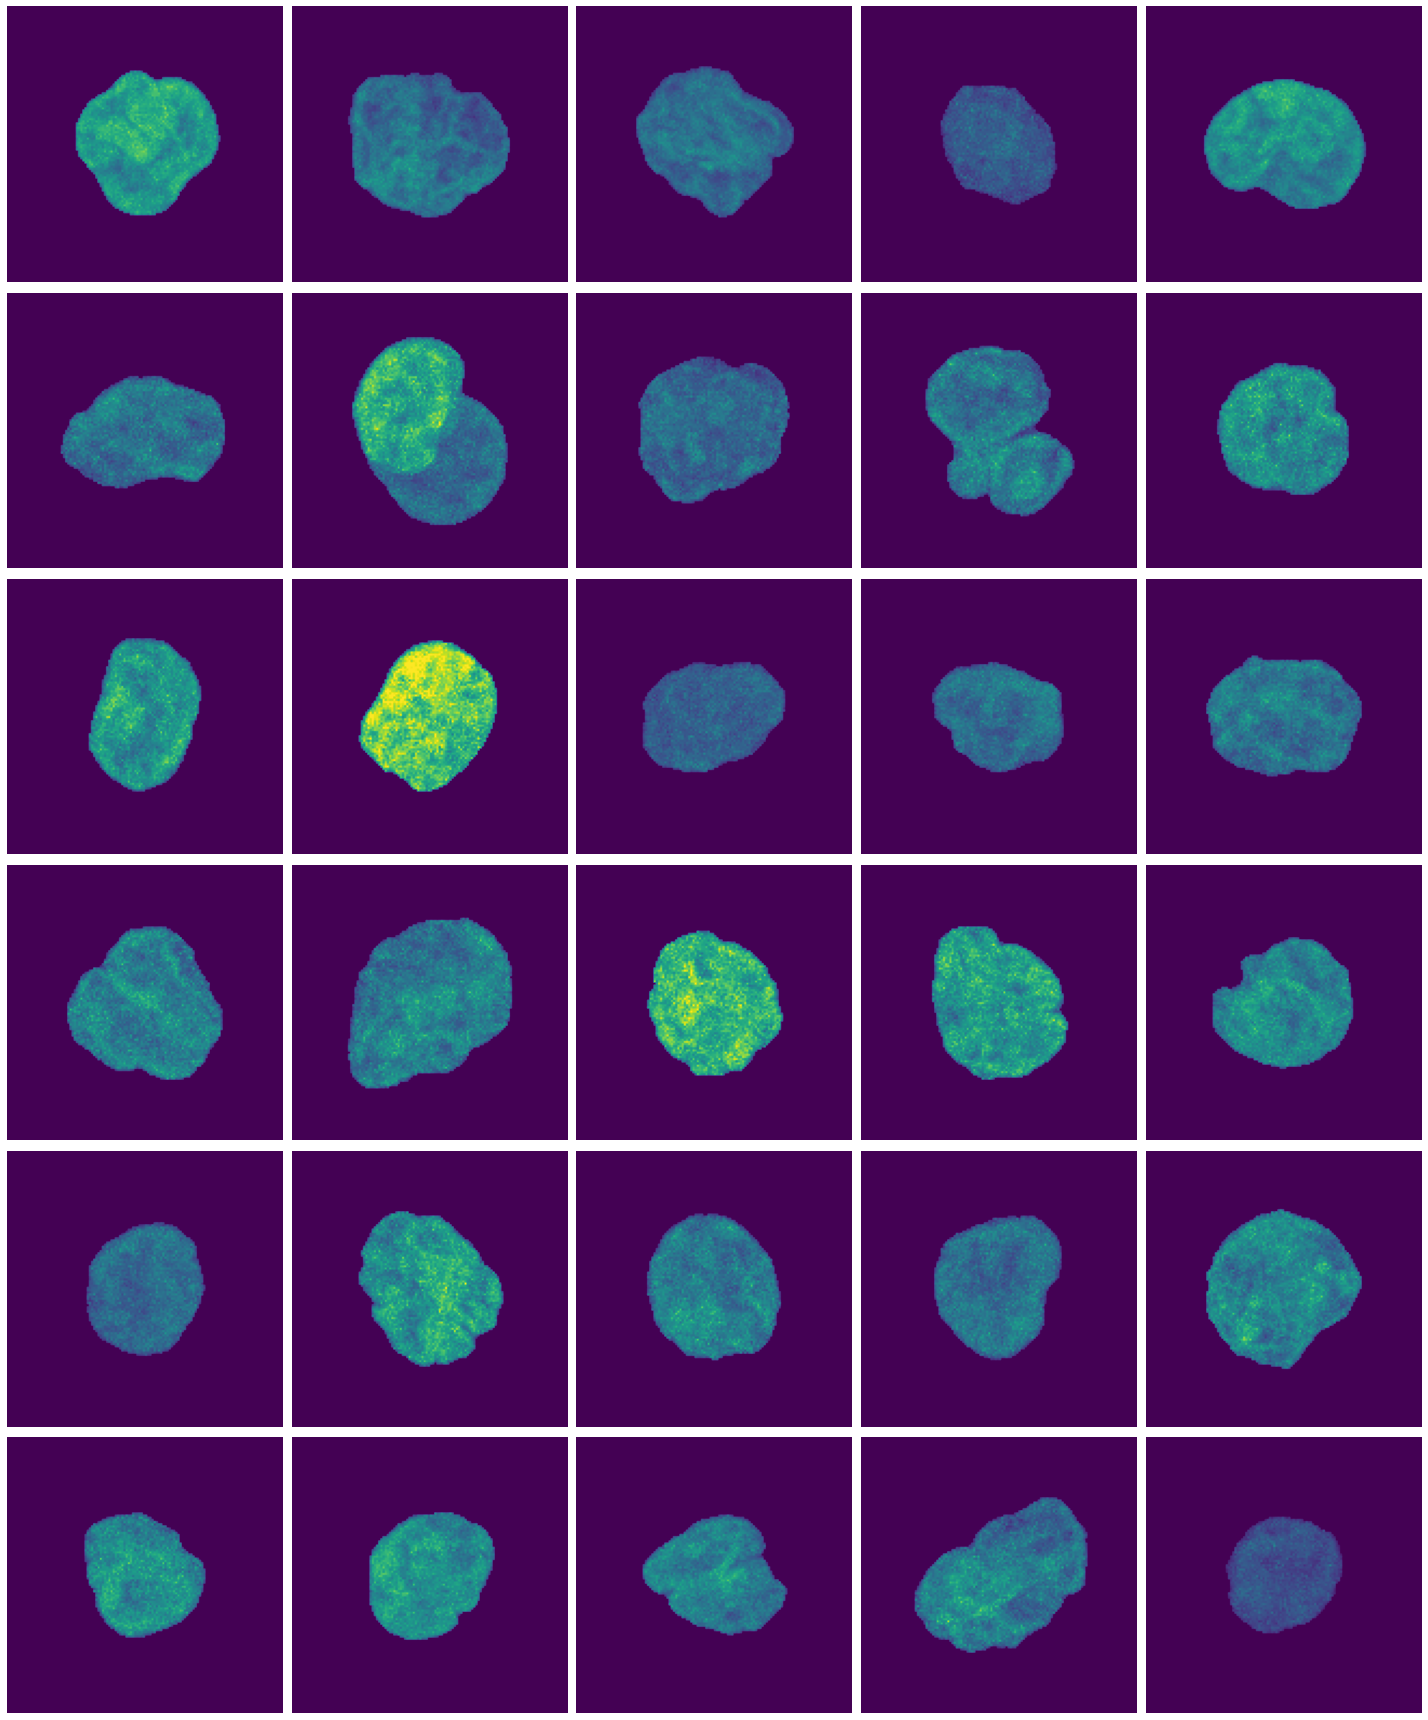

<IPython.core.display.Javascript object>

In [88]:
fig, ax = visualize_images(cd16_img_dict["cd16-"], ncols=5, nrows=6)